# Single Server Example to show Metastability

In [1]:
# IMPORTANT: THE PATH IS CURRENTLY HARDCODED. CHANGE IT TO POINT TO YOUR LOCAL COPY OF `metafor`
import os, sys
sys.path.append("/Users/rupak/Code/metafor")
sys.path.append("/Users/rupak/Code/metafor/metafor")
sys.path.append(".")

In [2]:
import math
import numpy as np
from numpy import linspace
import pandas
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

from metafor.dsl.dsl import Server, Work, Source, Program
from metafor.model.single_server.ctmc import SingleServerCTMC
from metafor.analysis.experiment import Parameter, ParameterList
from metafor.analysis.visualize import Visualizer


## Defining the program

In [3]:


def program():
        # api = { "insert": Work(1/.016, [],) }
        api = { "insert": Work(62.5, [],) }
        server = Server("52", api, qsize=1000, orbit_size=3, thread_pool=100)
        src = Source('client', 'insert', 6200, timeout=3, retries=4)
        p = Program("Service52")
        p.add_server(server)
        p.add_source(src)
        p.connect('client', '52')
        return p

def basic_stats(p: Program):
        p.print()
        print("Building CTMC")
        ctmc: SingleServerCTMC = p.build()
        print("Computing stationary distribution")
        pi = ctmc.get_stationary_distribution()
        print("Average queue size = ", ctmc.main_queue_size_average(pi))
        print("Mixing time = ", ctmc.get_mixing_time())
        # S1 = ctmc.set_construction([[0, int(.3*ctmc.main_queue_size)]], [[0, ctmc.retry_queue_size]])
        # S2 = ctmc.set_construction([[int(.9*ctmc.main_queue_size), ctmc.main_queue_size]], [[0, ctmc.retry_queue_size]])
        S1 = ctmc.set_construction([[0, int( 0.5 * ctmc.main_queue_size) ]], [[0, ctmc.retry_queue_size-1]])
        S2 = ctmc.set_construction([[int(0.95 * ctmc.main_queue_size), ctmc.main_queue_size-1]], [[0, ctmc.retry_queue_size-1]])
        ht_su = ctmc.get_hitting_time_average(S1, S2)
        ht_us = ctmc.get_hitting_time_average(S2, S1)
        print("Expected hitting time to go from high to low mode is", ht_us)
        print("Expected hitting time to go from low to high mode is", ht_su)
        h, s = ctmc.get_hitting_time_average_and_deviation(S1, S2)
        print("Hitting time = ", h, " s.d. = ", s)

In [4]:
p = program()
basic_stats(p)

Program:  Service52
client 	 -->	  52
Servers:  	 52: serves insert@62.500000 [q 1000 orbit 3 threads 100]
Sources:  	 client: generates insert: (arr 6200.000000, to 3, re 4)
Building CTMC
Program:  Service52 , Number of states =  3000
Computing stationary distribution
Average queue size =  [210.88108284]
[-24900.49434821+0.j -24900.26923265+0.j -24900.15891801+0.j ...
  -3117.82589803+0.j  -4145.99371226+0.j  -3932.46577335+0.j]
Sorted eigenvalues (real parts): [ 5.52919211e-11 -1.74183071e-01 -3.33334394e-01 ... -2.49001589e+04
 -2.49002692e+04 -2.49004943e+04]
Mixing time =  38.14295015952862
Maximum error in solving the linear equation is 1.7695128917694092e-07
Maximum error in solving the linear equation is 9.276845958083868e-11
Expected hitting time to go from high to low mode is 7.392273026855946
Expected hitting time to go from low to high mode is 2469.39336158919
Maximum error in solving the linear equation is 1.7695128917694092e-07
Hitting time =  2469.39336158919  s.d. =  49

## Running parameter sweeps.

We define ``full queue'' to be a state where more than  98% of the queue is full. The hitting time experiment checks what is the expected time to go from a full queue to a queue that is only 80% full. 
(TODO: We should make these numbers parameterized, and also check how long it takes to go back to the average queue length.)

In [5]:
from metafor.analysis.single_server.latency_experiment import HittingTimeExperiment


def test_hitting_times(p):
    qsizes = Parameter(("server", "52", "qsize"), range(16000, 22000, 1000))
    print("Computing exact recovery times")
    ht = HittingTimeExperiment(p)
    ht.sweep(ParameterList([qsizes]))


## TAKES TOO LONG FOR LONG QUEUES
# test_hitting_times(program())

## Visualizing the dynamics. 

The idea is that instead of actually computing the hitting times, we visualize the "general direction" of the dynamics. It seems that this visualization is quite useful to figure out what parameters to simulate.

Program:  Service52
client 	 -->	  52
Servers:  	 52: serves insert@62.500000 [q 20000 orbit 1000 threads 100]
Sources:  	 client: generates insert: (arr 6200.000000, to 3, re 4)
found solution is [17430.56504859   187.53943376]
obj value is 0.0001825345644176948
Optimization terminated successfully.
found an almost equilibrium point


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


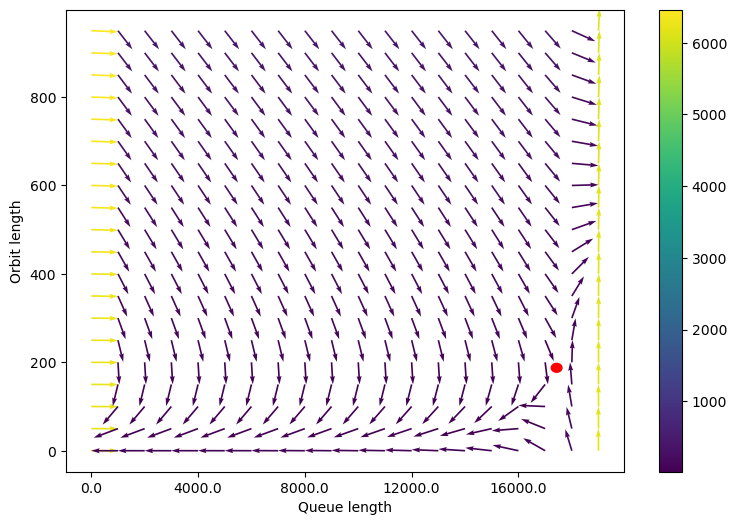

In [6]:
def program():
        # api = { "insert": Work(1/.016, [],) }
        api = { "insert": Work(62.5, [],) }
        server = Server("52", api, qsize=20000, orbit_size=1000, thread_pool=100)
        src = Source('client', 'insert', 6200, timeout=3, retries=4)
        p = Program("Service52")
        p.add_server(server)
        p.add_source(src)
        p.connect('client', '52')
        return p

v = Visualizer(program())
v.visualize(show_equilibrium=True)

Prediction: One should see a metastable behavior for a queue size around 20000 and orbit around 50.

Unfortunately, these experiments take *a long* time to run --- so we can try to reproduce similar behaviors on a scaled down version of the system.

In [7]:
def scaled_program():
        # essentially scale down rates by a 100
        
        api = { "insert": Work(.625, [],) }
        server = Server("52", api, qsize=200, orbit_size=10, thread_pool=100)
        src = Source('client', 'insert', 62, timeout=3, retries=4)
        p = Program("Service52")
        p.add_server(server)
        p.add_source(src)
        p.connect('client', '52')
        return p

sp = scaled_program()

In [8]:
basic_stats(sp)


Program:  Service52
client 	 -->	  52
Servers:  	 52: serves insert@0.625000 [q 200 orbit 10 threads 100]
Sources:  	 client: generates insert: (arr 62.000000, to 3, re 4)
Building CTMC
Program:  Service52 , Number of states =  2000
Computing stationary distribution
Average queue size =  [173.61809432]
[-7.98024212e-14+0.j         -2.67490799e+02+4.30136526j
 -2.67490799e+02-4.30136526j ... -6.16216673e+01+0.j
 -6.00136851e+01+0.09119107j -6.00136851e+01-0.09119107j]
Sorted eigenvalues (real parts): [-7.98024212e-14 -3.75041231e-02 -2.11058980e-01 ... -2.66445101e+02
 -2.67490799e+02 -2.67490799e+02]
Mixing time =  177.15002070221152
Maximum error in solving the linear equation is 3.183231456205249e-12
Maximum error in solving the linear equation is 3.637978807091713e-11
Expected hitting time to go from high to low mode is 371.86666248428196
Expected hitting time to go from low to high mode is 47.530352815456965
Maximum error in solving the linear equation is 3.183231456205249e-12
Hitt

We now try to see how long it takes for a full queue to become small, as the size of the queue increases.

In [9]:
def test_hitting_times_scaled(p):
    qsizes = Parameter(("server", "52", "qsize"), range(500, 2000, 100))
    print("Computing exact recovery times")
    ht = HittingTimeExperiment(p)
    ht.sweep(ParameterList([qsizes]))

test_hitting_times_scaled(sp)

Computing exact recovery times


Running experiment with parameters  {'server': {'52': {'qsize': 500}}}
Program:  Service52
client 	 -->	  52
Servers:  	 52: serves insert@0.625000 [q 500 orbit 10 threads 100]
Sources:  	 client: generates insert: (arr 62.000000, to 3, re 4)
Program:  Service52 , Number of states =  5000
Maximum error in solving the linear equation is 6.548361852765083e-11
Analysis time =  2.073780059814453  seconds
Running experiment with parameters  {'server': {'52': {'qsize': 600}}}
Program:  Service52
client 	 -->	  52
Servers:  	 52: serves insert@0.625000 [q 600 orbit 10 threads 100]
Sources:  	 client: generates insert: (arr 62.000000, to 3, re 4)
Program:  Service52 , Number of states =  6000
Maximum error in solving the linear equation is 1.6007106751203537e-10
Analysis time =  3.103179931640625  seconds
Running experiment with parameters  {'server': {'52': {'qsize': 700}}}
Program:  Service52
client 	 -->	  52
Servers:  	 52: serves insert@0.625000 [q 700 orb

Program:  Service52
client 	 -->	  52
Servers:  	 52: serves insert@0.625000 [q 200 orbit 10 threads 100]
Sources:  	 client: generates insert: (arr 62.000000, to 3, re 4)
found solution is [100.60077044   2.22577704]
obj value is 0.014468611706823002
Optimization terminated successfully.


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


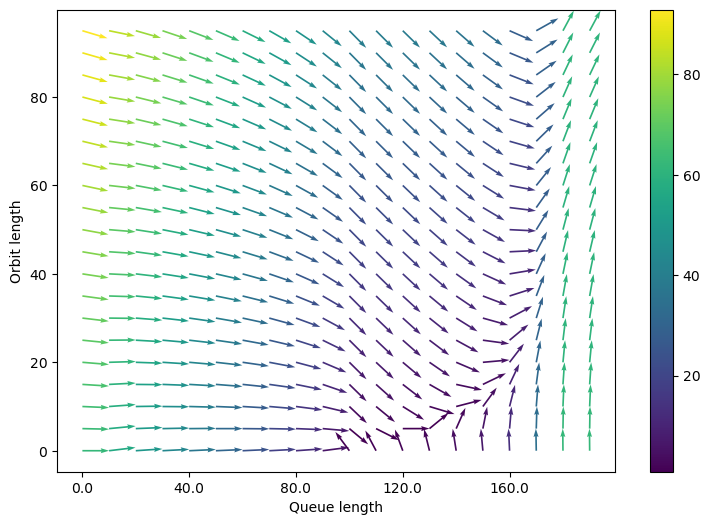

In [10]:
sp = scaled_program()
v = Visualizer(sp)
v.visualize(qrange=200, orange=100, show_equilibrium=True)

The previous experiment on Hitting times checked how long it takes to go from 98% full queue to 80% full queue. This may not be a very good indicator, we should see how long it takes for a full queue to get back to average queue size in normal mode. The next experiment checks this.

In [11]:
from metafor.analysis.experiment import Experiment


class SweepHittingTimes(Experiment):
    def __init__(self, p: Program, lowfactor: float=0.8, hifactor: float=0.98):
        self.p = p

        self.lowfactor = lowfactor
        self.fullfactor = hifactor

        self.main_color = "#A9A9A9"
        self.fade_color = "#D3D3D3"

    def plot(
            self,
            figure_name: str,
            x_axis: str,
            y_axis: str,
            x_vals,
            hitting_times,
    ):
        plt.rc("font", size=14)
        plt.rcParams["figure.figsize"] = [5, 5]
        plt.rcParams["figure.autolayout"] = True

        plt.figure()  # row 0, col 0
        plt.plot(x_vals, hitting_times, color=self.main_color)

        plt.xlabel(x_axis, fontsize=14)
        plt.ylabel(y_axis, fontsize=14)
        plt.grid("on")
        plt.xlim(min(x_vals), max(x_vals))
        plt.show()
        plt.close()

    def build(self, param) -> Program:
        return self.update(self.p, param)

    def analyze(self, param_setting, p: Program):
        ctmc = p.build()
        pi = ctmc.get_stationary_distribution()
        qavg = ctmc.main_queue_size_average(pi)[0]
        print("Average queue = ", qavg)
        # average = ctmc.set_construction([[0, int(1 * ctmc.thread_pool)]], [[0, ctmc.retry_queue_size]])
        # average = ctmc.set_construction([[0, 100]], [[0, ctmc.retry_queue_size]])
        average = ctmc.set_construction([[0, max(1, int(self.lowfactor * qavg))]], [[0, ctmc.retry_queue_size - 1]])
        full = ctmc.set_construction([[int(self.fullfactor * ctmc.main_queue_size), ctmc.main_queue_size]],
                                   [[max(1, ctmc.retry_queue_size - 10), ctmc.retry_queue_size - 1]])
        
        hitting_time, sd = ctmc.get_hitting_time_average_and_deviation(full, average)
        print("Param setting = ", param_setting, " Hitting time = ", hitting_time, " s.d.=", sd)
        return [param_setting, hitting_time, sd]

    def show(self, results):
        # print(results)
        PARAMETER = "parameter"
        HITTING_TIME = "Hitting time"
        STANDARD_DEV = "s.d."
        columns = [PARAMETER, HITTING_TIME, STANDARD_DEV]

        pd = pandas.DataFrame(results, columns=columns)

        print(pd)

In [12]:
from metafor.analysis.single_server.latency_experiment import MixingTimeExperiment


def scaled_program():
        api = { "insert": Work(62.5, [],) }
        server = Server("52", api, qsize=300, orbit_size=20, thread_pool=1)
        src = Source('client', 'insert', 62, timeout=3, retries=4)
        p = Program("Service52")
        p.add_server(server)
        p.add_source(src)
        p.connect('client', '52')
        return p

sp = scaled_program()
# ctmc: SingleServerCTMC = sp.build()
# print("Computing stationary distribution")
# pi = ctmc.get_stationary_distribution()
# q_avg = ctmc.main_queue_size_average(pi)
# print("Average queue size = ", q_avg)

# print("Getting mixing times...", ctmc.get_mixing_time())

# S1 = ctmc.set_construction([[0, int( 0.5 * ctmc.main_queue_size) ]], [[0, ctmc.retry_queue_size-1]])
# S2 = ctmc.set_construction([[int(0.95 * ctmc.main_queue_size), ctmc.main_queue_size-1]], [[0, ctmc.retry_queue_size-1]])
## ht_su = ctmc.get_hitting_time_average(S1, S2)
# ht_us = ctmc.get_hitting_time_average(S2, S1)
# print("Expected hitting time to go from high to low mode is", ht_us)
## print("Expected hitting time to go from low to high mode is", ht_su)


# As queues get large, hitting times should 
qsizes = Parameter(("server", "52", "qsize"), range(150, 450, 50))
t = SweepHittingTimes(sp, 0.8, 0.98) # how much time does it take a 98% filled queue to get to 80% of the average queue
t.sweep(ParameterList([qsizes]))





Running experiment with parameters  {'server': {'52': {'qsize': 150}}}
Program:  Service52
client 	 -->	  52
Servers:  	 52: serves insert@62.500000 [q 150 orbit 20 threads 1]
Sources:  	 client: generates insert: (arr 62.000000, to 3, re 4)
Program:  Service52 , Number of states =  3000
Average queue =  68.36698425919917
Maximum error in solving the linear equation is 6.366462912410498e-12
Param setting =  {'server': {'52': {'qsize': 150}}}  Hitting time =  80.4409390599656  s.d.= 9.032985580819549
Analysis time =  7.8232808113098145  seconds
Running experiment with parameters  {'server': {'52': {'qsize': 200}}}
Program:  Service52
client 	 -->	  52
Servers:  	 52: serves insert@62.500000 [q 200 orbit 20 threads 1]
Sources:  	 client: generates insert: (arr 62.000000, to 3, re 4)
Program:  Service52 , Number of states =  4000
Average queue =  182.09633333810308
Maximum error in solving the linear equation is 3.2741809263825417e-11
Param setting =  {'server': {'52': {'qsize': 200}}} 

In [13]:
sp = scaled_program()
# checking queue sizes around the point in which the latency is around 3 time units

qsizes = Parameter(("server", "52", "qsize"), range(180, 190, 1))
t = SweepHittingTimes(sp, 0.8, 0.98) # how much time does it take a 98% filled queue to get to 80% of the average queue
t.sweep(ParameterList([qsizes]))



Running experiment with parameters  {'server': {'52': {'qsize': 180}}}
Program:  Service52
client 	 -->	  52
Servers:  	 52: serves insert@62.500000 [q 180 orbit 20 threads 1]
Sources:  	 client: generates insert: (arr 62.000000, to 3, re 4)
Program:  Service52 , Number of states =  3600
Average queue =  139.5173098788091
Maximum error in solving the linear equation is 2.546585164964199e-11
Param setting =  {'server': {'52': {'qsize': 180}}}  Hitting time =  298.7123051792101  s.d.= 17.28625315953459
Analysis time =  12.421533107757568  seconds
Running experiment with parameters  {'server': {'52': {'qsize': 181}}}
Program:  Service52
client 	 -->	  52
Servers:  	 52: serves insert@62.500000 [q 181 orbit 20 threads 1]
Sources:  	 client: generates insert: (arr 62.000000, to 3, re 4)
Program:  Service52 , Number of states =  3620
Average queue =  142.39089292200498
Maximum error in solving the linear equation is 3.2741809263825417e-11
Param setting =  {'server': {'52': {'qsize': 181}}}

In [14]:
# Mixing time is an approximate measure of the hitting time... this is useful when the hitting time is hard to compute
# because the linear system does not converge quickly.
# Mixing time computation needs finding the second largest eigenvalue of the matrix
sp = scaled_program()
qsizes = Parameter(("server", "52", "qsize"), range(160, 200, 10))

t = MixingTimeExperiment(sp)
t.sweep(ParameterList([qsizes]))




Running experiment with parameters  {'server': {'52': {'qsize': 160}}}
Program:  Service52
client 	 -->	  52
Servers:  	 52: serves insert@62.500000 [q 160 orbit 20 threads 1]
Sources:  	 client: generates insert: (arr 62.000000, to 3, re 4)
Program:  Service52 , Number of states =  3200
[-259.34927096+0.j         -257.84671169+0.03960735j
 -257.84671169-0.03960735j ...  -13.82917313+0.j
  -15.78802589+0.j          -15.78801586+0.j        ]
Sorted eigenvalues (real parts): [-4.79837524e-13 -1.72634938e-02 -8.28622406e-02 ... -2.57846712e+02
 -2.57846712e+02 -2.59349271e+02]
Analysis time =  9.050565958023071  seconds
Running experiment with parameters  {'server': {'52': {'qsize': 170}}}
Program:  Service52
client 	 -->	  52
Servers:  	 52: serves insert@62.500000 [q 170 orbit 20 threads 1]
Sources:  	 client: generates insert: (arr 62.000000, to 3, re 4)
Program:  Service52 , Number of states =  3400
[-262.58890679+0.j         -260.92024632+0.j
 -259.60403147+0.07067733j ...  -22.998

Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 4.000000, to 9, re 3)
	 client-d: generates delete: (arr 4.750000, to 9, re 3)
Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 4.000000, to 9, re 3)
	 client-d: generates delete: (arr 4.750000, to 9, re 3)
found solution is [70.76203207 15.49464726]
obj value is 0.002965511105839122
Optimization terminated successfully.
found an almost equilibrium point


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


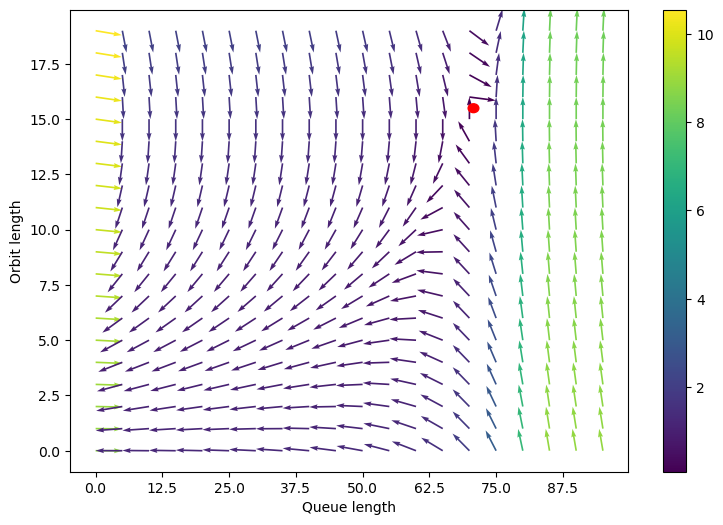

Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 4.500000, to 9, re 3)
	 client-d: generates delete: (arr 4.750000, to 9, re 3)
Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 4.500000, to 9, re 3)
	 client-d: generates delete: (arr 4.750000, to 9, re 3)
found solution is [65.08976653  9.23407645]
obj value is 0.0006371442896817224
Optimization terminated successfully.
found an almost equilibrium point


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


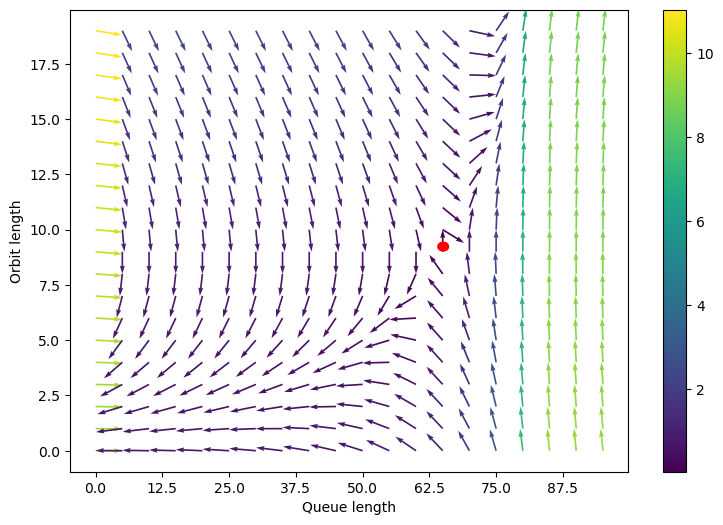

Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 5.000000, to 9, re 3)
	 client-d: generates delete: (arr 4.750000, to 9, re 3)
Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 5.000000, to 9, re 3)
	 client-d: generates delete: (arr 4.750000, to 9, re 3)
found solution is [51.61380785  3.01144735]
obj value is 1.4464885650899047e-06
Optimization terminated successfully.
found an almost equilibrium point


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


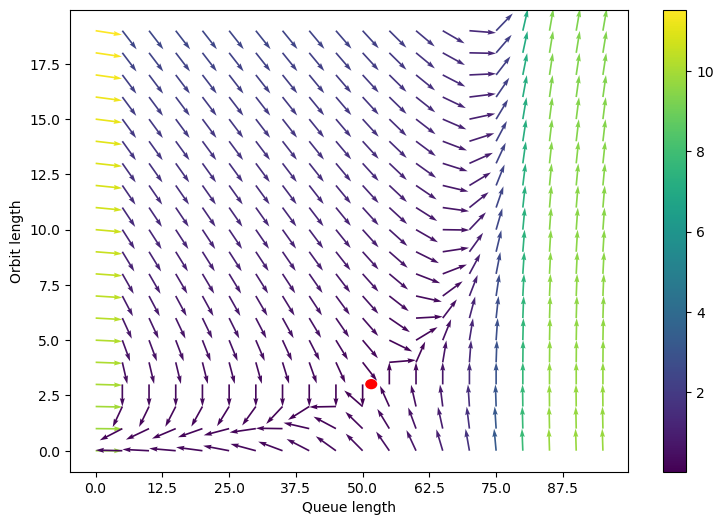

Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 5.500000, to 9, re 3)
	 client-d: generates delete: (arr 4.750000, to 9, re 3)
Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 5.500000, to 9, re 3)
	 client-d: generates delete: (arr 4.750000, to 9, re 3)
found solution is [1.3109948 0.       ]
obj value is 0.06250167450984098
Optimization terminated successfully.


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


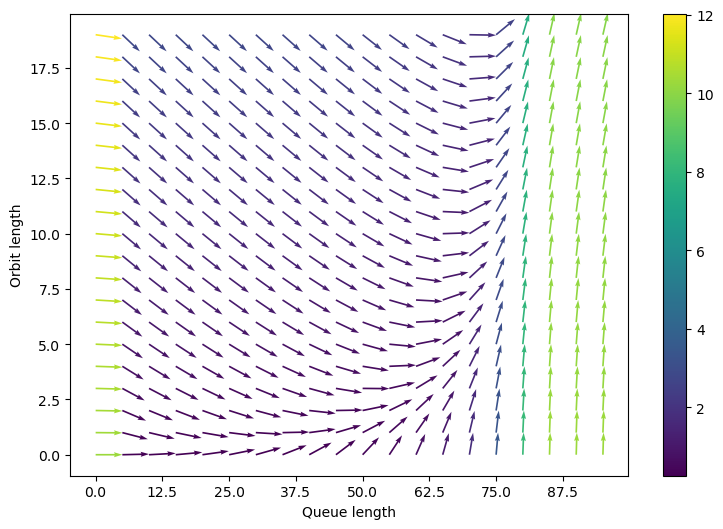

Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 6.000000, to 9, re 3)
	 client-d: generates delete: (arr 4.750000, to 9, re 3)
Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 6.000000, to 9, re 3)
	 client-d: generates delete: (arr 4.750000, to 9, re 3)
found solution is [8.16053071 0.        ]
obj value is 0.5626635842521713
Optimization terminated successfully.


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


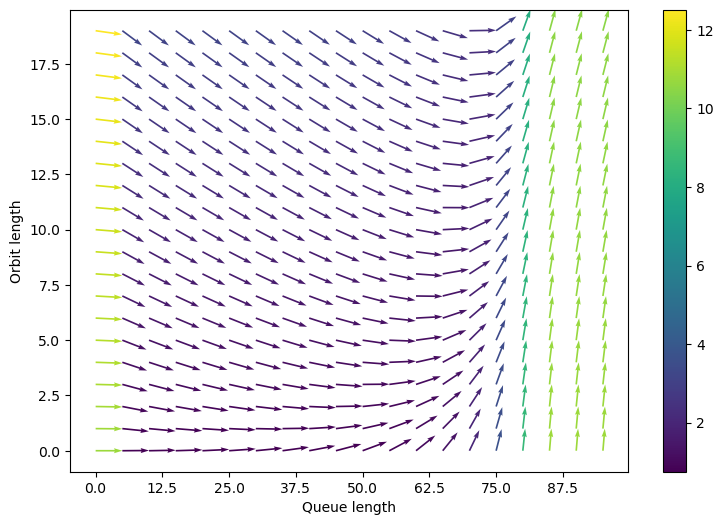

In [15]:


def program():
        # api = { "insert": Work(1/.016, [],) }
        api = { "insert": Work(10, [],), "delete": Work(10, []) }
        server = Server("52", api, qsize=100, orbit_size=10, thread_pool=1)
        src1 = Source('client-i', 'insert', 4.75, timeout=9, retries=3)
        src2 = Source('client-d', 'delete', 4.75, timeout=9, retries=3)

        p = Program("Service52")

        p.add_server(server)
        p.add_sources([src1, src2])
        p.connect('client-i', '52')
        p.connect('client-d', '52')
        return p

v = Visualizer(program())
p = Parameter(('source', 'client-i', 'arrival_rate'), linspace(4, 6, 5))
v.visualize(ParameterList([p]), qrange=100, orange=20, show_equilibrium=True)

Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 4.000000, to 9, re 2)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 4.000000, to 9, re 2)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
found solution is [72.49727895 20.        ]
obj value is 0.03734238852553895
Optimization terminated successfully.


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


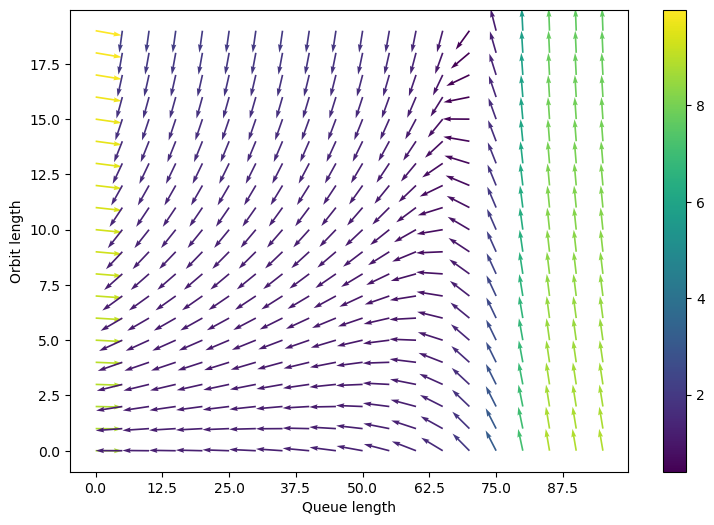

Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 4.000000, to 9, re 3)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 4.000000, to 9, re 3)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
found solution is [72.29877195 19.88888658]
obj value is 0.0011288242939056542
Optimization terminated successfully.
found an almost equilibrium point


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


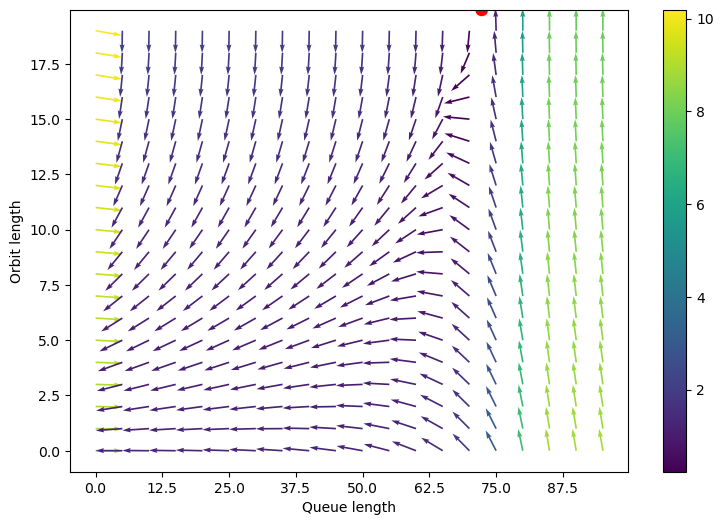

Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 4.000000, to 9, re 4)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 4.000000, to 9, re 4)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
found solution is [71.12878336 17.62340811]
obj value is 0.00038962860645560713
Optimization terminated successfully.
found an almost equilibrium point


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


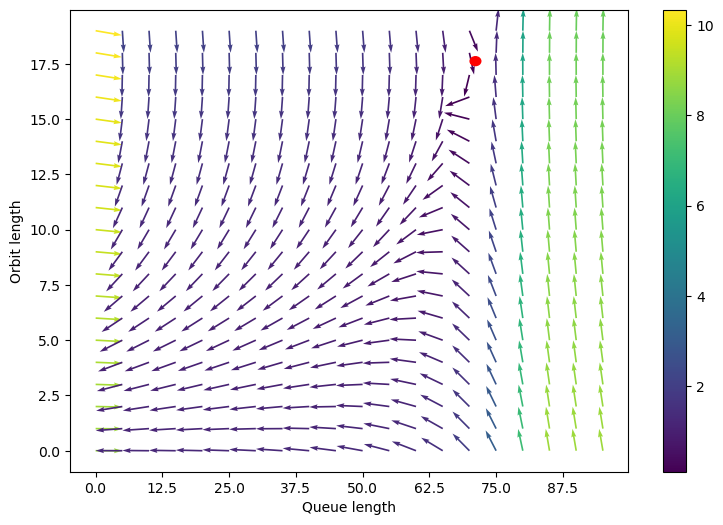

Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 4.000000, to 9, re 5)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 4.000000, to 9, re 5)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
found solution is [70.40277559 15.87675368]
obj value is 0.0008470875581085824
Optimization terminated successfully.
found an almost equilibrium point


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


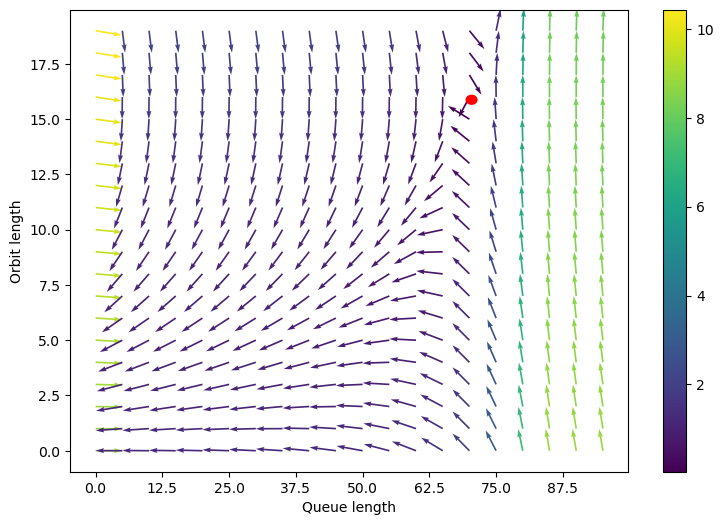

Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 4.000000, to 9, re 6)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 4.000000, to 9, re 6)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
found solution is [70.93898574 15.61939323]
obj value is 0.0008115191115520472
Optimization terminated successfully.
found an almost equilibrium point


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


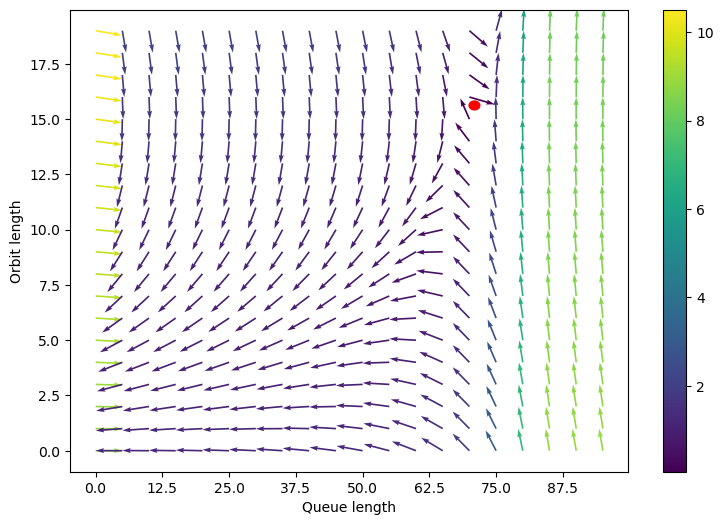

Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 4.000000, to 9, re 7)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 4.000000, to 9, re 7)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
found solution is [69.31908509 14.32149769]
obj value is 0.002472100359667639
Optimization terminated successfully.
found an almost equilibrium point


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


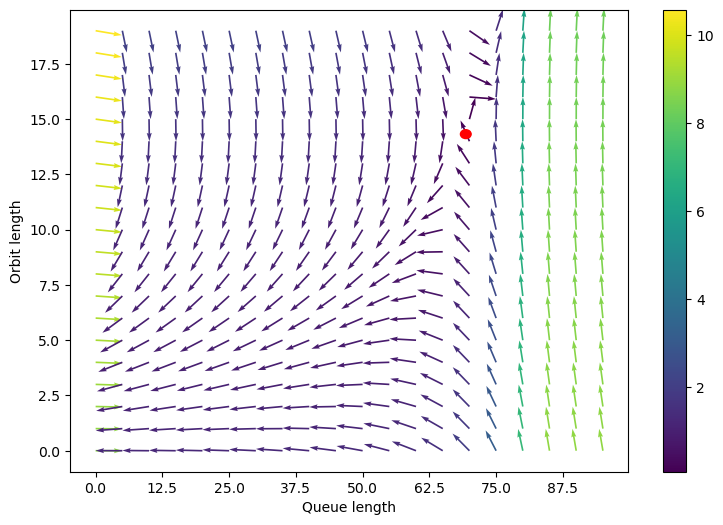

Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 4.500000, to 9, re 2)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 4.500000, to 9, re 2)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
found solution is [69.93351681 14.01974881]
obj value is 0.0004260020111261801
Optimization terminated successfully.
found an almost equilibrium point


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


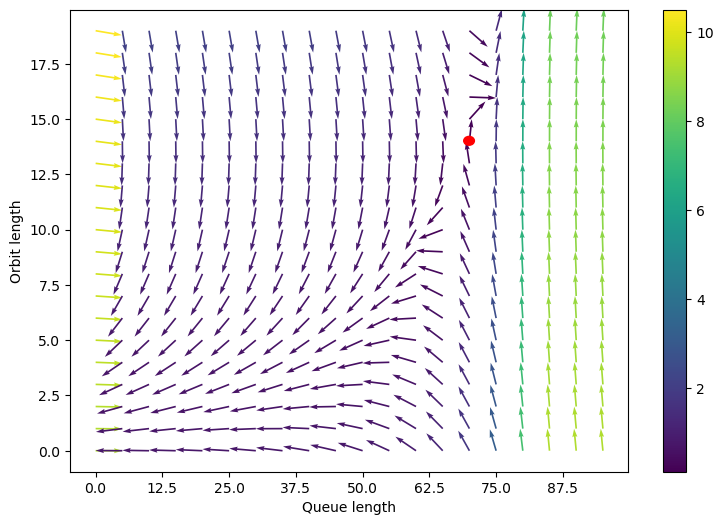

Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 4.500000, to 9, re 3)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 4.500000, to 9, re 3)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
found solution is [67.00361805 11.39328868]
obj value is 2.0506745521405335e-06
Optimization terminated successfully.
found an almost equilibrium point


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


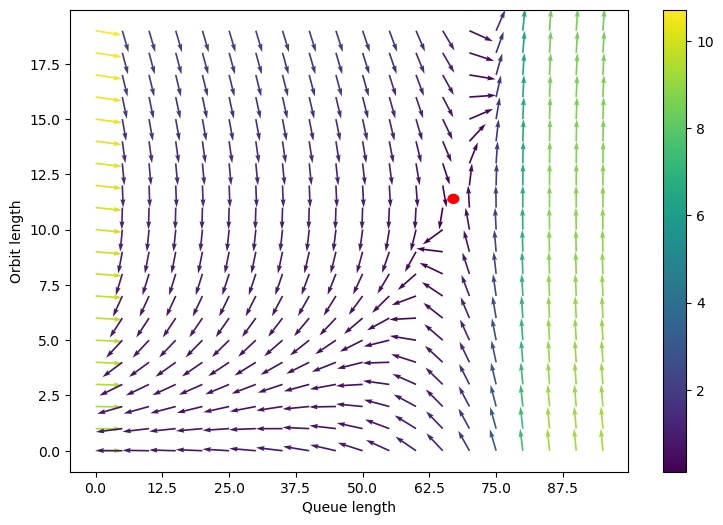

Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 4.500000, to 9, re 4)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 4.500000, to 9, re 4)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
found solution is [66.17962723 10.28591816]
obj value is 3.668185613064038e-05
Optimization terminated successfully.
found an almost equilibrium point


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


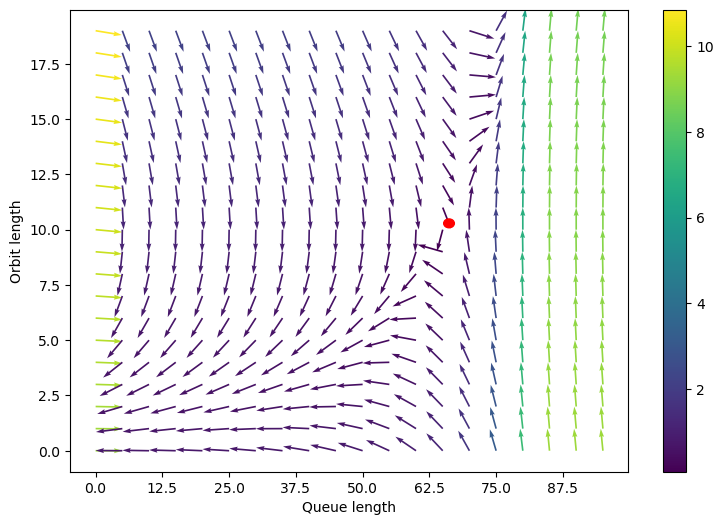

Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 4.500000, to 9, re 5)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 4.500000, to 9, re 5)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
found solution is [65.69366198  9.41252331]
obj value is 0.00012409333761415238
Optimization terminated successfully.
found an almost equilibrium point


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


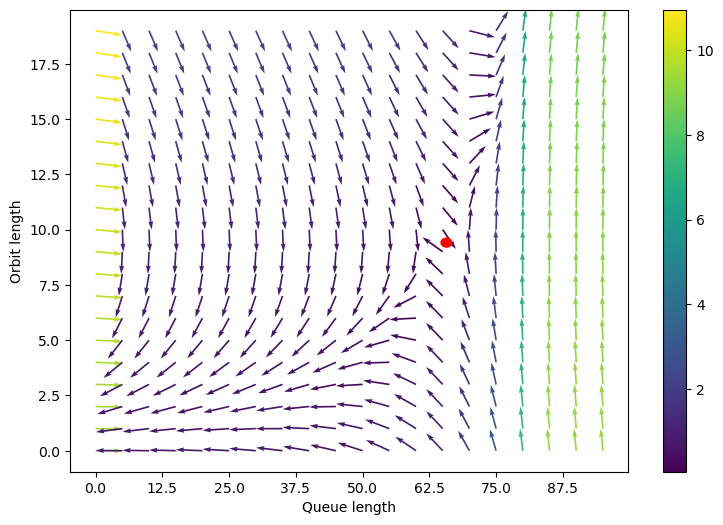

Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 4.500000, to 9, re 6)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 4.500000, to 9, re 6)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
found solution is [65.5289355   9.25745215]
obj value is 0.00043118582743813895
Optimization terminated successfully.
found an almost equilibrium point


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


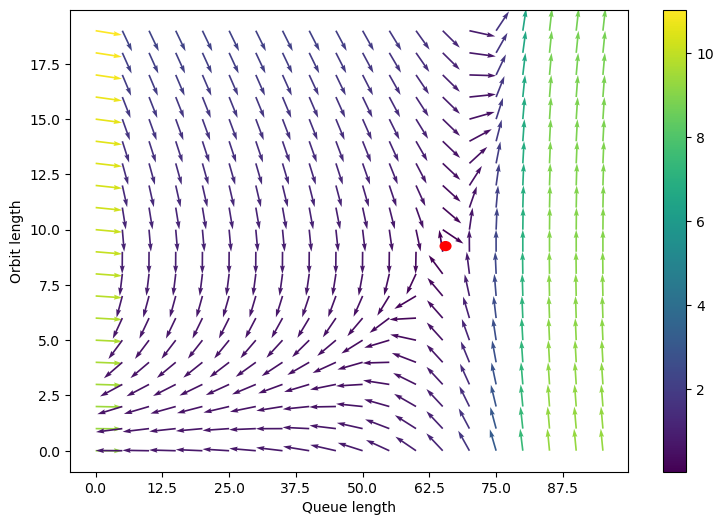

Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 4.500000, to 9, re 7)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 4.500000, to 9, re 7)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
found solution is [64.68981407  8.59754105]
obj value is 0.00022641613107261
Optimization terminated successfully.
found an almost equilibrium point


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


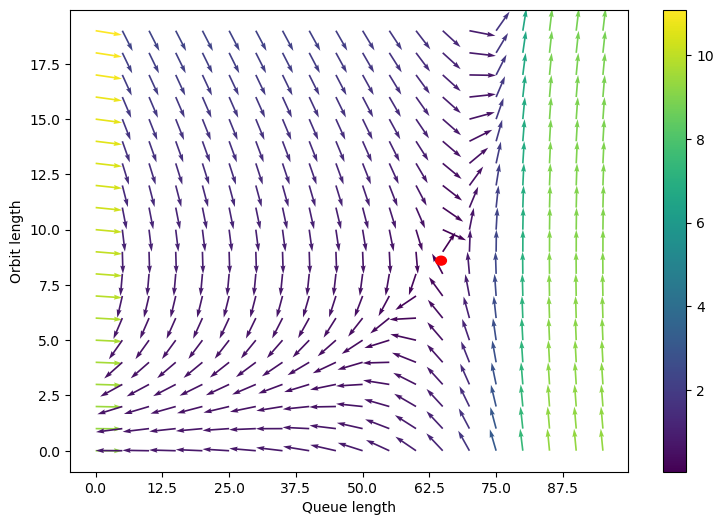

Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 5.000000, to 9, re 2)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 5.000000, to 9, re 2)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
found solution is [56.1843595   4.37600916]
obj value is 1.843947002004179e-05
Optimization terminated successfully.
found an almost equilibrium point


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


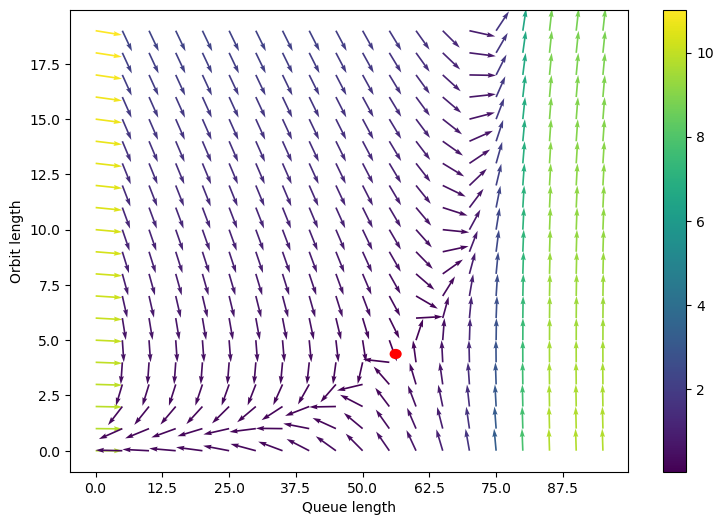

Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 5.000000, to 9, re 3)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 5.000000, to 9, re 3)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
found solution is [54.21733567  3.74034595]
obj value is 4.840529022517528e-06
Optimization terminated successfully.
found an almost equilibrium point


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


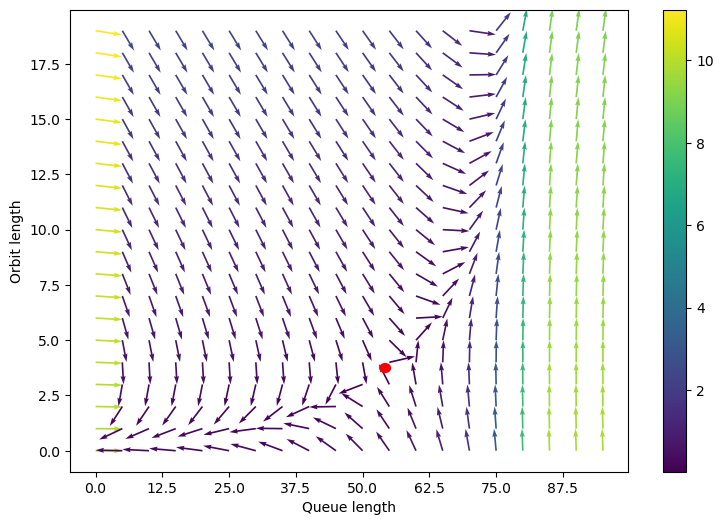

Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 5.000000, to 9, re 4)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 5.000000, to 9, re 4)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
found solution is [52.89427053  3.27326337]
obj value is 4.4545990375177485e-05
Optimization terminated successfully.
found an almost equilibrium point


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


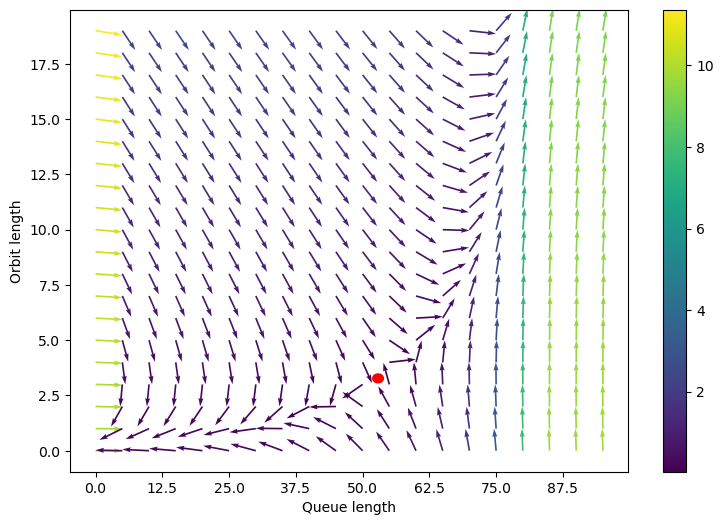

Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 5.000000, to 9, re 5)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 5.000000, to 9, re 5)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
found solution is [51.63682561  3.05455181]
obj value is 5.23592810601389e-05
Optimization terminated successfully.
found an almost equilibrium point


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


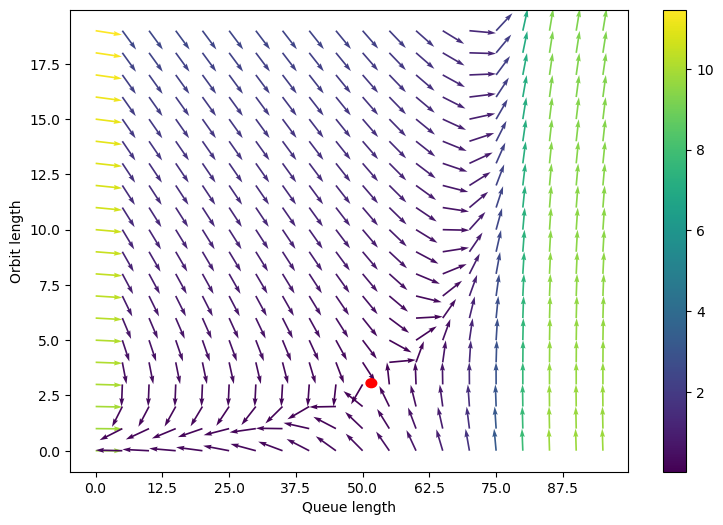

Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 5.000000, to 9, re 6)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 5.000000, to 9, re 6)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
found solution is [51.88999776  3.00465319]
obj value is 6.165489538974502e-06
Optimization terminated successfully.
found an almost equilibrium point


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


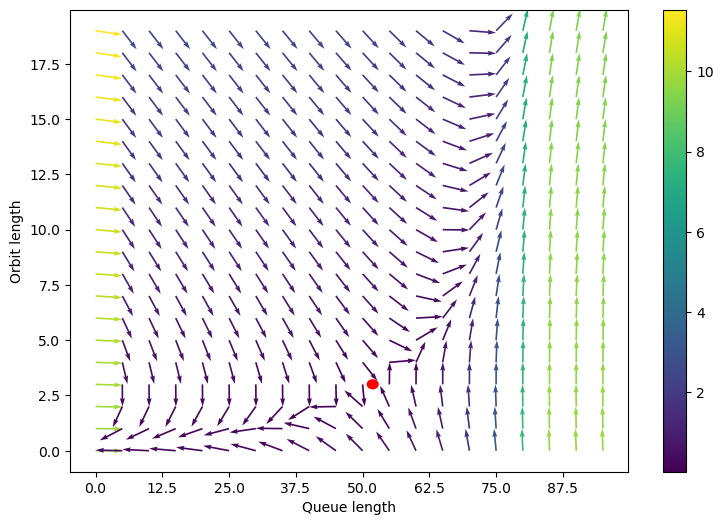

Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 5.000000, to 9, re 7)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 5.000000, to 9, re 7)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
found solution is [50.0504877   2.83683366]
obj value is 1.9963016408869172e-05
Optimization terminated successfully.
found an almost equilibrium point


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


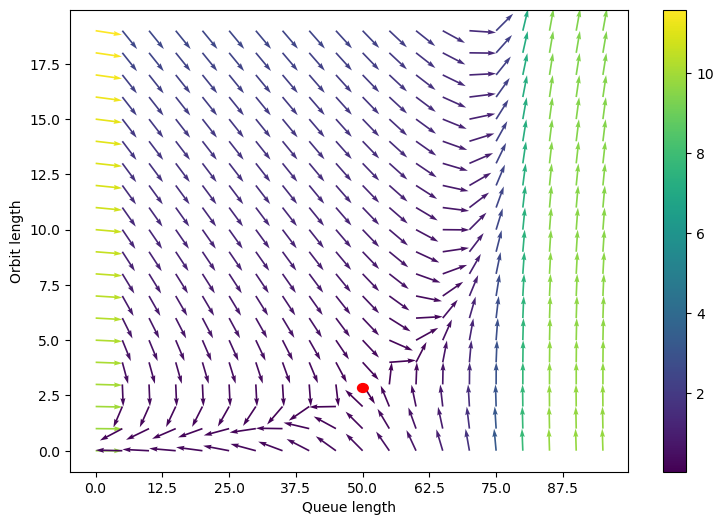

Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 5.500000, to 9, re 2)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 5.500000, to 9, re 2)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
found solution is [1.66795782 0.        ]
obj value is 0.06250167450984098
Optimization terminated successfully.


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


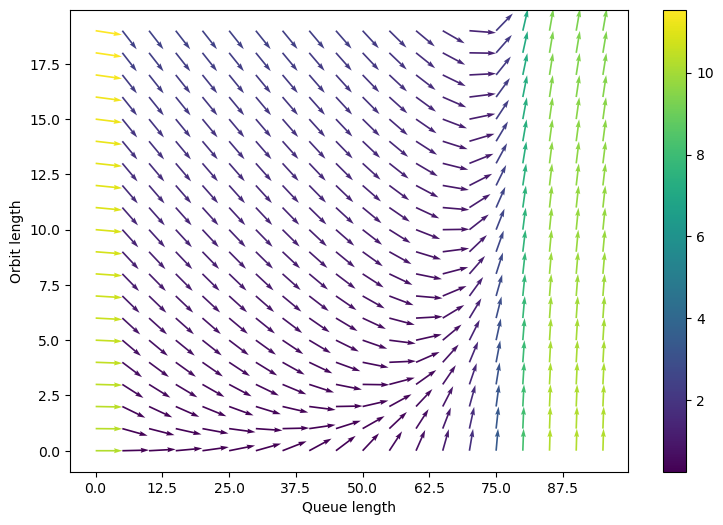

Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 5.500000, to 9, re 3)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 5.500000, to 9, re 3)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
found solution is [3.90616001 0.        ]
obj value is 0.06251650491263178
Optimization terminated successfully.


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


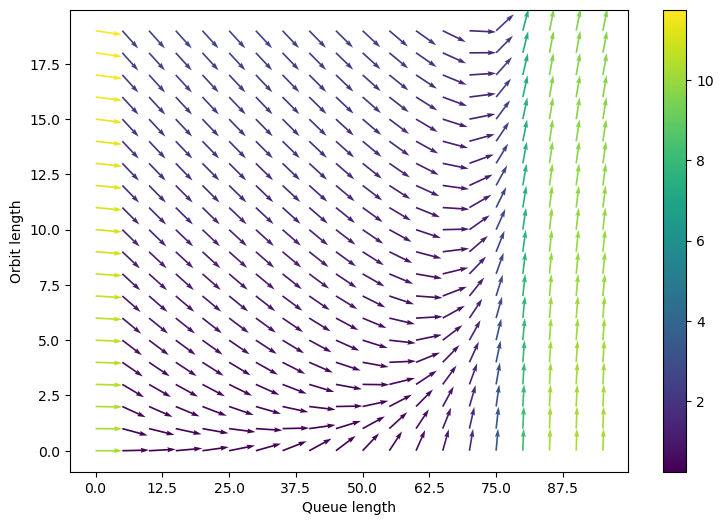

Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 5.500000, to 9, re 4)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 5.500000, to 9, re 4)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
found solution is [2.72782718 0.        ]
obj value is 0.0625070077247221
Optimization terminated successfully.


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


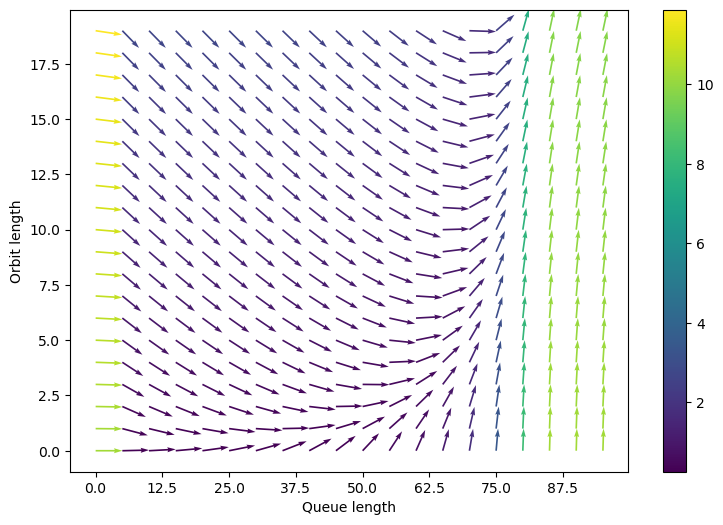

Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 5.500000, to 9, re 5)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 5.500000, to 9, re 5)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
found solution is [1.49107399 0.        ]
obj value is 0.06250167450984098
Optimization terminated successfully.


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


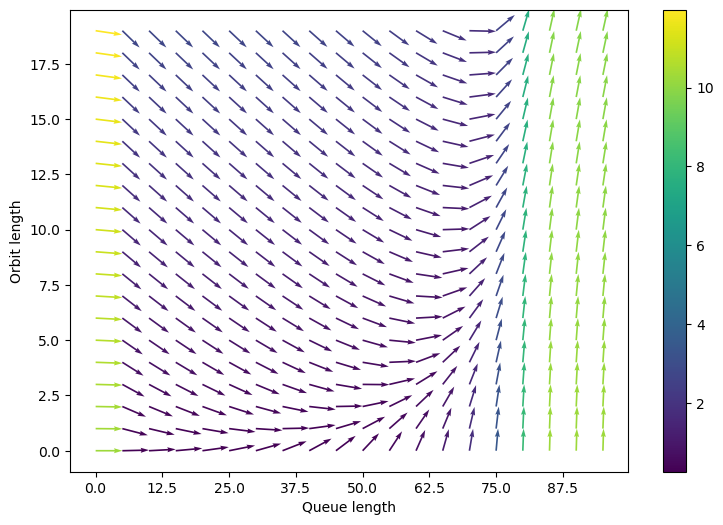

Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 5.500000, to 9, re 6)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 5.500000, to 9, re 6)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
found solution is [1.44729334 0.        ]
obj value is 0.06250167450984098
Optimization terminated successfully.


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


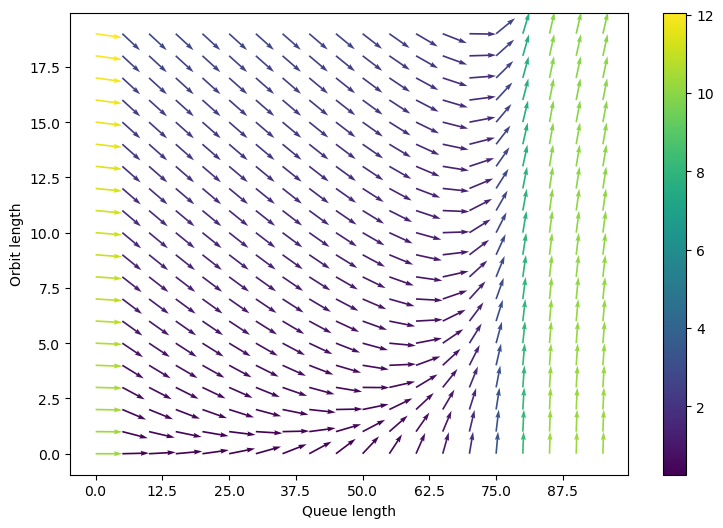

Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 5.500000, to 9, re 7)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 5.500000, to 9, re 7)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
found solution is [2.35686251 0.        ]
obj value is 0.0625070077247221
Optimization terminated successfully.


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


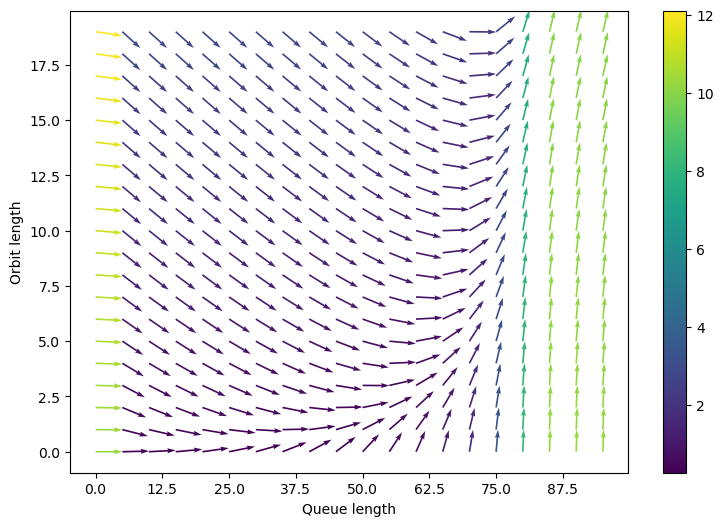

Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 6.000000, to 9, re 2)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 6.000000, to 9, re 2)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
found solution is [4.72513286 0.        ]
obj value is 0.5625338020551649
Optimization terminated successfully.


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


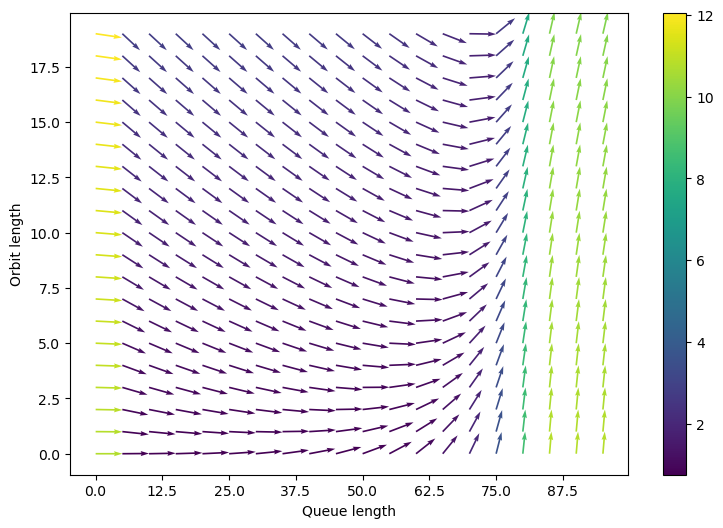

Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 6.000000, to 9, re 3)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 6.000000, to 9, re 3)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
found solution is [3.34942792 0.        ]
obj value is 0.5625181544220441
Optimization terminated successfully.


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


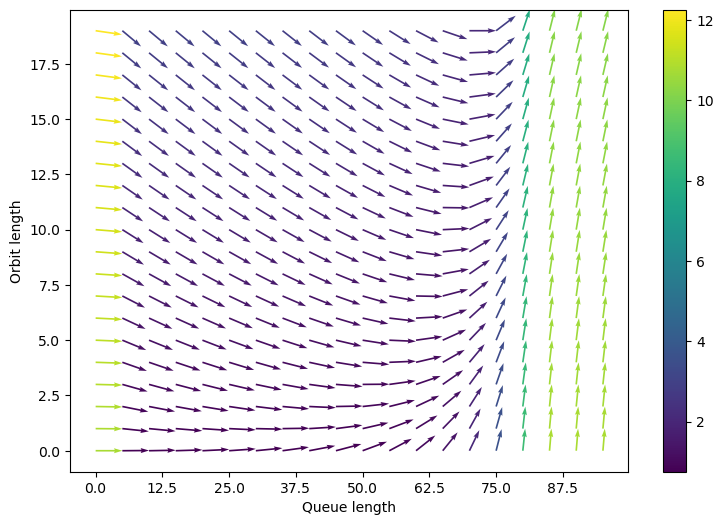

Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 6.000000, to 9, re 4)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 6.000000, to 9, re 4)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
found solution is [6.96066322 0.        ]
obj value is 0.5625835607414734
Optimization terminated successfully.


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


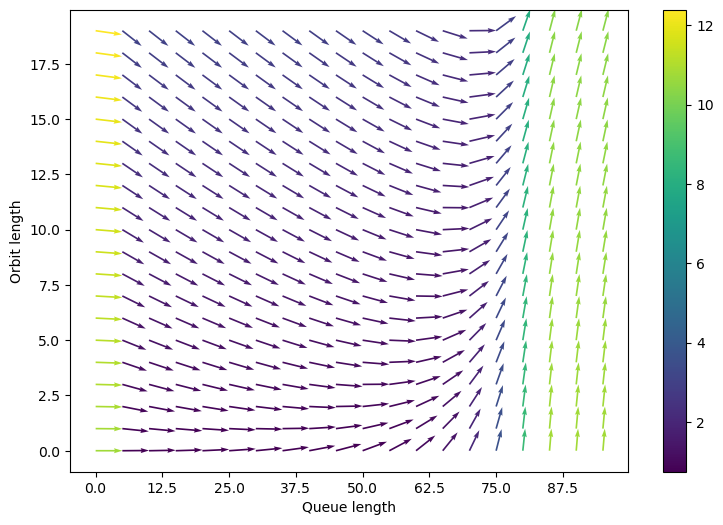

Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 6.000000, to 9, re 5)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 6.000000, to 9, re 5)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
found solution is [4.64129012 0.        ]
obj value is 0.5625338020551649
Optimization terminated successfully.


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


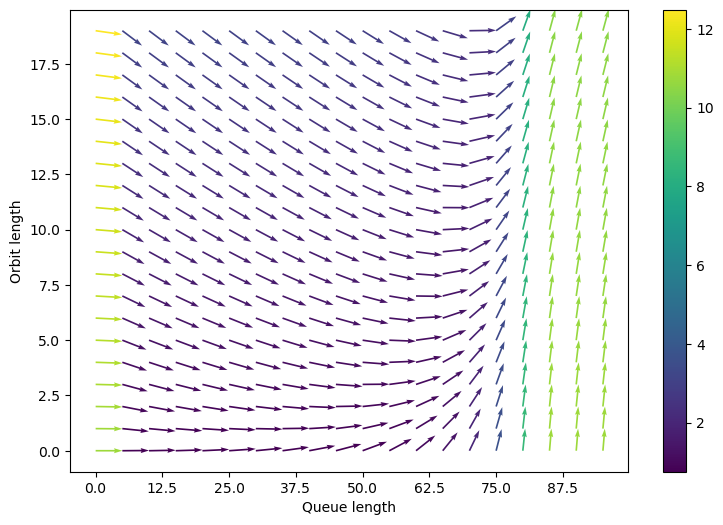

Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 6.000000, to 9, re 6)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 6.000000, to 9, re 6)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
found solution is

/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


 [4.36454105 0.        ]
obj value is 0.5625338020551649
Optimization terminated successfully.


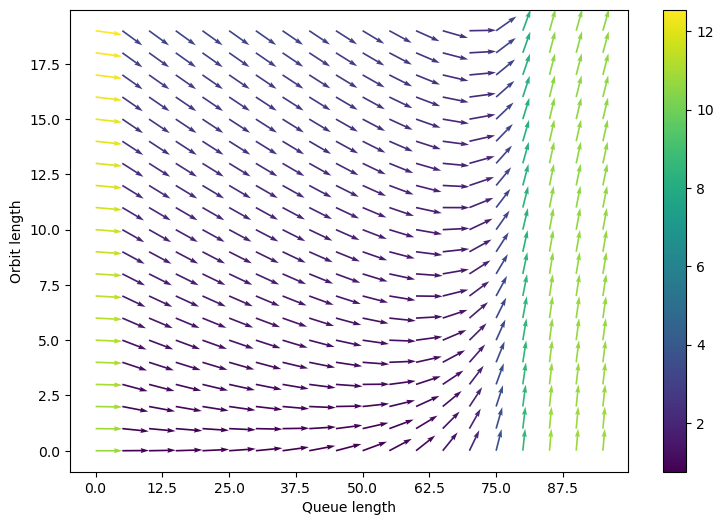

Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 6.000000, to 9, re 7)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 6.000000, to 9, re 7)
	 client-d: generates delete: (arr 4.750000, to 9, re 0)
found solution is [8.77431736 0.        ]
obj value is 0.5626635842521713
Optimization terminated successfully.


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


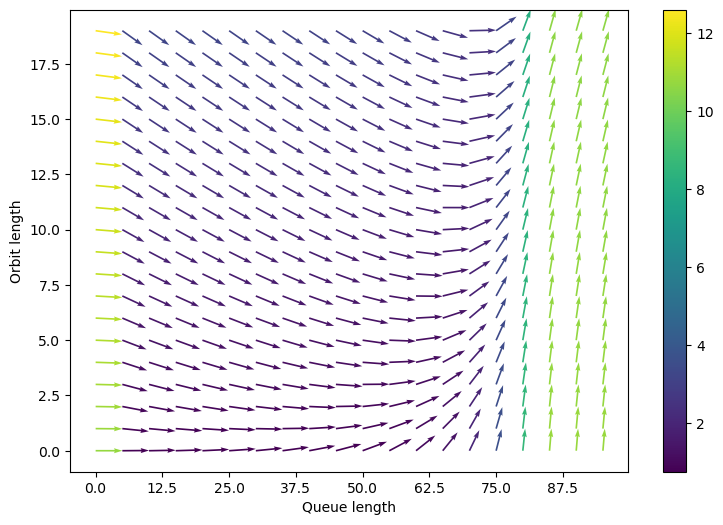

In [16]:
def program():
        # api = { "insert": Work(1/.016, [],) }
        api = { "insert": Work(10, [],), "delete": Work(10, []) }
        server = Server("52", api, qsize=100, orbit_size=10, thread_pool=1)
        src1 = Source('client-i', 'insert', 4.75, timeout=9, retries=0)
        src2 = Source('client-d', 'delete', 4.75, timeout=9, retries=0)

        p = Program("Service52")

        p.add_server(server)
        p.add_sources([src1, src2])
        p.connect('client-i', '52')
        p.connect('client-d', '52')
        return p

v = Visualizer(program())
p1 = Parameter(('source', 'client-i', 'arrival_rate'), linspace(4, 6, 5))
p2 = Parameter(('source', 'client-i', 'retries'), range(2, 8))
v.visualize(ParameterList([p1, p2]), qrange=100, orange=20, show_equilibrium=True)

Program:  Service52
client 	 -->	  52
Servers:  	 52: serves insert@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client: generates insert: (arr 9.900000, to 100, re 0)
found solution is [54.79258628  0.06817646]
obj value is 0.010000007121696582
Optimization terminated successfully.


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


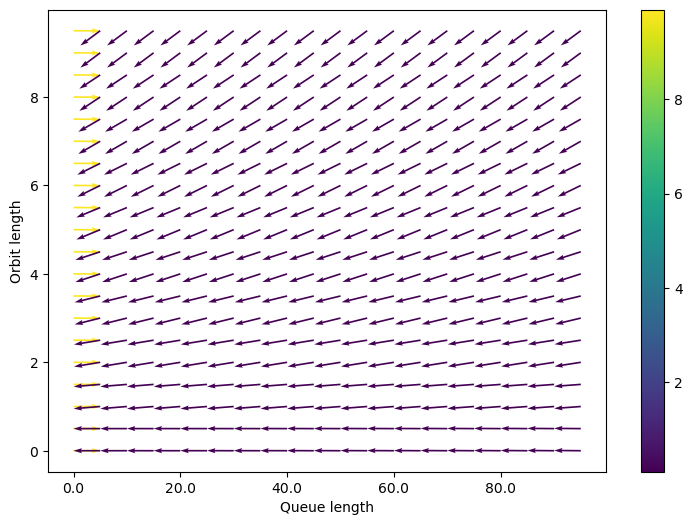

In [17]:
def program():
        api = { "insert": Work(10, [],) }
        server = Server("52", api, qsize=100, orbit_size=10, thread_pool=1)
        src = Source('client', 'insert', 9.9, timeout=100, retries=0)

        p = Program("Service52")

        p.add_server(server)
        p.add_sources([src])
        p.connect('client', '52')
        return p

v = Visualizer(program())
v.visualize()

In [18]:
def program():
        api = { "insert": Work(10, [],) }
        server = Server("52", api, qsize=200, orbit_size=20, thread_pool=1)
        src = Source('client', 'insert', 5, timeout=3, retries=5)

        p = Program("Service52")

        p.add_server(server)
        p.add_sources([src])
        p.connect('client', '52')
        return p  

p = program()
ctmc: SingleServerCTMC = p.build()
print("Computing stationary distribution")
pi = ctmc.get_stationary_distribution()
print("Average queue size = ", ctmc.main_queue_size_average(pi))
# print("Mixing time = ", ctmc.get_mixing_time())
# S1 = ctmc.set_construction([[0, int(.3*ctmc.main_queue_size)]], [[0, ctmc.retry_queue_size]])
# S2 = ctmc.set_construction([[int(.9*ctmc.main_queue_size), ctmc.main_queue_size]], [[0, ctmc.retry_queue_size]])
S1 = ctmc.set_construction([[0, int( 0.1 * ctmc.main_queue_size) ]], [[0, ctmc.retry_queue_size-1]])
S2 = ctmc.set_construction([[int(0.5 * ctmc.main_queue_size), ctmc.main_queue_size-1]], [[0, ctmc.retry_queue_size-1]])
# ht_su = ctmc.get_hitting_time_average(S1, S2)
ht_us = ctmc.get_hitting_time_average(S2, S1)
print("Expected hitting time to go from high to low mode is", ht_us)
# print("Expected hitting time to go from low to high mode is", ht_su)


Program:  Service52 , Number of states =  4000
Computing stationary distribution
Average queue size =  [1.03221299]
Maximum error in solving the linear equation is 3.026798367500305e-09
Expected hitting time to go from high to low mode is 131970.55190201572


In [19]:
name = 'PisaSimulationSandbox'
op = 'delayedEcho'
timeout = 5.0
retries = 5
service = 0.1
baseline_rps = 5
effective_queue_bound = 150 + 31

def new_program(rps: int, queue_bound: int, orbit: int = 30):
    api = { op: Work(1/service, []) }
    server = Server('PisaSim', api, qsize=queue_bound, orbit_size=orbit, thread_pool=1)
    src = Source("Client", op, rps, timeout=timeout, retries=retries)
    p = Program(name)
    p.add_server(server)
    p.add_source(src)
    p.connect('Client', 'PisaSim')
    return p

def visualize(p: Program, rps: int):
    v = Visualizer(p)
    v.visualize(show_equilibrium=False)
    


Program:  PisaSimulationSandbox
Client 	 -->	  PisaSim
Servers:  	 PisaSim: serves delayedEcho@10.000000 [q 181 orbit 30 threads 1]
Sources:  	 Client: generates delayedEcho: (arr 5.000000, to 5, re 5)


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


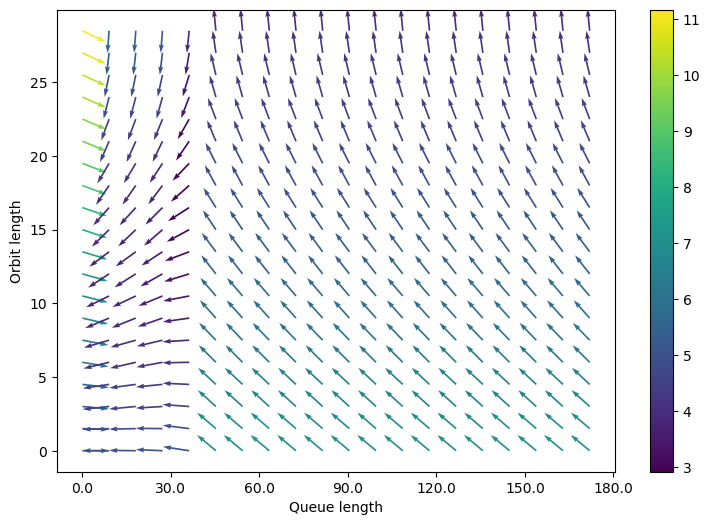



Running experiment with parameters  {'server': {'PisaSim': {'qsize': 100}}}
Program:  PisaSimulationSandbox
Client 	 -->	  PisaSim
Servers:  	 PisaSim: serves delayedEcho@10.000000 [q 100 orbit 30 threads 1]
Sources:  	 Client: generates delayedEcho: (arr 5.000000, to 5, re 5)
Program:  PisaSimulationSandbox , Number of states =  3000
Average queue =  1.0007048891761892
Maximum error in solving the linear equation is 4.547473508864641e-12
Param setting =  {'server': {'PisaSim': {'qsize': 100}}}  Hitting time =  352.25364308994244  s.d.= 19.106637514040646
Analysis time =  8.32861065864563  seconds
Running experiment with parameters  {'server': {'PisaSim': {'qsize': 150}}}
Program:  PisaSimulationSandbox
Client 	 -->	  PisaSim
Servers:  	 PisaSim: serves delayedEcho@10.000000 [q 150 orbit 30 threads 1]
Sources:  	 Client: generates delayedEcho: (arr 5.000000, to 5, re 5)
Program:  PisaSimulationSandbox , Number of states =  4500
Average queue =  1.0007048893427577
Maximum error in sol

In [20]:
p = new_program(baseline_rps, effective_queue_bound)
visualize(p, baseline_rps)

# As queues get large, hitting times should increase
qsizes = Parameter(("server", "PisaSim", "qsize"), range(100, 250, 50))
t = SweepHittingTimes(p, 1.0, 0.98) # how much time does it take a 98% filled queue to get to the average queue
t.sweep(ParameterList([qsizes]))

Program:  PisaSimulationSandbox
Client 	 -->	  PisaSim
Servers:  	 PisaSim: serves delayedEcho@10.000000 [q 150 orbit 30 threads 1]
Sources:  	 Client: generates delayedEcho: (arr 2.000000, to 5, re 5)
Program:  PisaSimulationSandbox
Client 	 -->	  PisaSim
Servers:  	 PisaSim: serves delayedEcho@10.000000 [q 150 orbit 30 threads 1]
Sources:  	 Client: generates delayedEcho: (arr 2.000000, to 5, re 5)
found solution is [127.46353354  30.        ]
obj value is 10.0
Optimization terminated successfully.


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


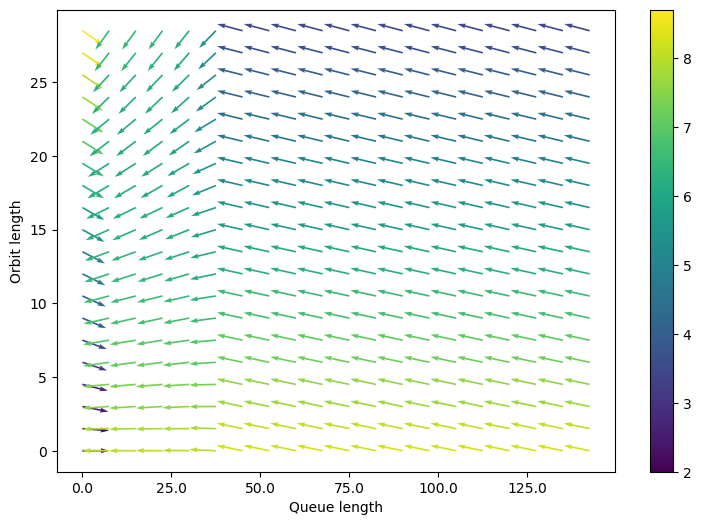

Program:  PisaSimulationSandbox
Client 	 -->	  PisaSim
Servers:  	 PisaSim: serves delayedEcho@10.000000 [q 150 orbit 30 threads 1]
Sources:  	 Client: generates delayedEcho: (arr 2.428571, to 5, re 5)
Program:  PisaSimulationSandbox
Client 	 -->	  PisaSim
Servers:  	 PisaSim: serves delayedEcho@10.000000 [q 150 orbit 30 threads 1]
Sources:  	 Client: generates delayedEcho: (arr 2.428571, to 5, re 5)
found solution is [43.80267893 30.        ]
obj value is 6.881554454351498
Optimization terminated successfully.


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


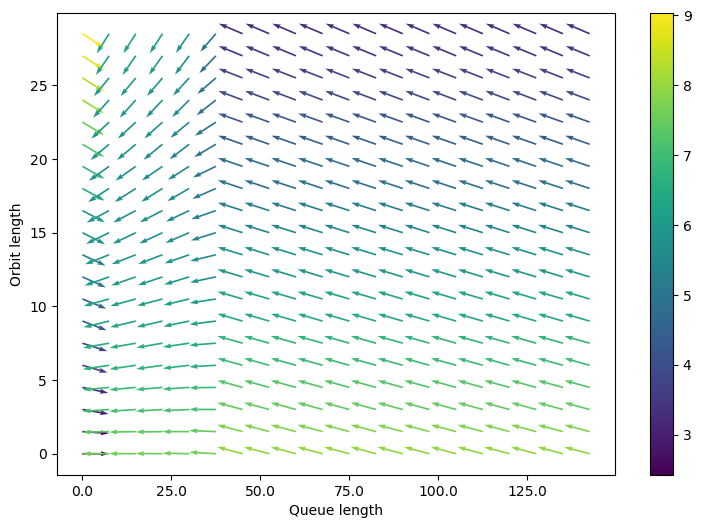

Program:  PisaSimulationSandbox
Client 	 -->	  PisaSim
Servers:  	 PisaSim: serves delayedEcho@10.000000 [q 150 orbit 30 threads 1]
Sources:  	 Client: generates delayedEcho: (arr 2.857143, to 5, re 5)
Program:  PisaSimulationSandbox
Client 	 -->	  PisaSim
Servers:  	 PisaSim: serves delayedEcho@10.000000 [q 150 orbit 30 threads 1]
Sources:  	 Client: generates delayedEcho: (arr 2.857143, to 5, re 5)
found solution is [146.69015087  30.        ]
obj value is 8.04081632653061
Optimization terminated successfully.


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


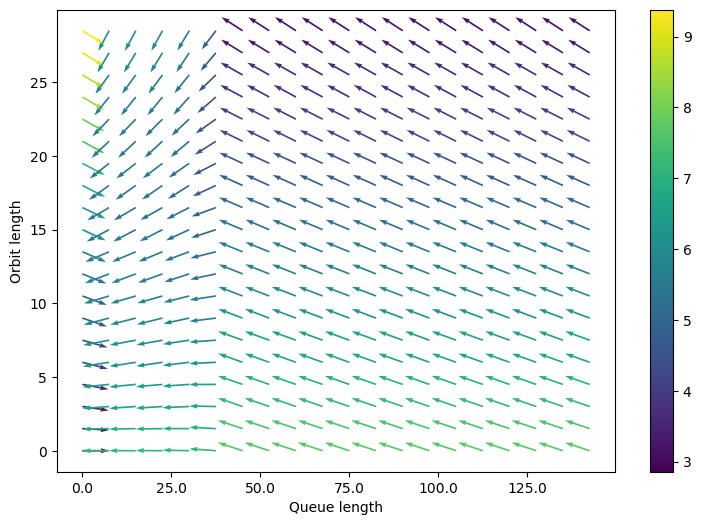

Program:  PisaSimulationSandbox
Client 	 -->	  PisaSim
Servers:  	 PisaSim: serves delayedEcho@10.000000 [q 150 orbit 30 threads 1]
Sources:  	 Client: generates delayedEcho: (arr 3.285714, to 5, re 5)
Program:  PisaSimulationSandbox
Client 	 -->	  PisaSim
Servers:  	 PisaSim: serves delayedEcho@10.000000 [q 150 orbit 30 threads 1]
Sources:  	 Client: generates delayedEcho: (arr 3.285714, to 5, re 5)
found solution is [119.11286902  30.        ]
obj value is 8.16326530612245
Optimization terminated successfully.


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


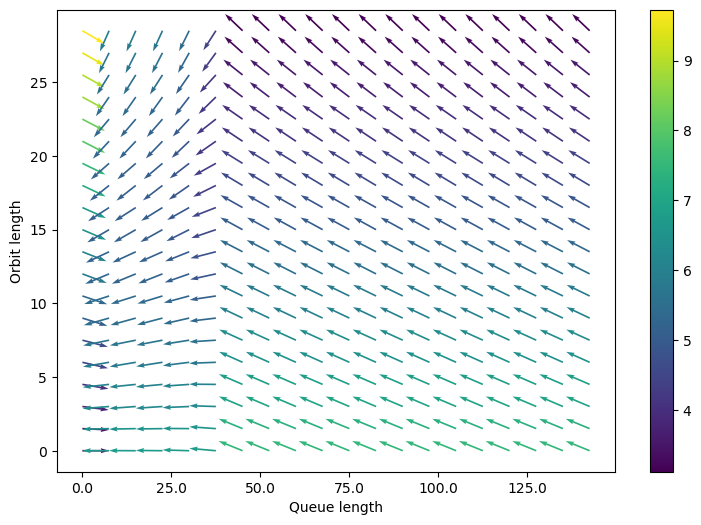

Program:  PisaSimulationSandbox
Client 	 -->	  PisaSim
Servers:  	 PisaSim: serves delayedEcho@10.000000 [q 150 orbit 30 threads 1]
Sources:  	 Client: generates delayedEcho: (arr 3.714286, to 5, re 5)
Program:  PisaSimulationSandbox
Client 	 -->	  PisaSim
Servers:  	 PisaSim: serves delayedEcho@10.000000 [q 150 orbit 30 threads 1]
Sources:  	 Client: generates delayedEcho: (arr 3.714286, to 5, re 5)
found solution is [42.41608757 30.        ]
obj value is 1.7321627869897944
Optimization terminated successfully.


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


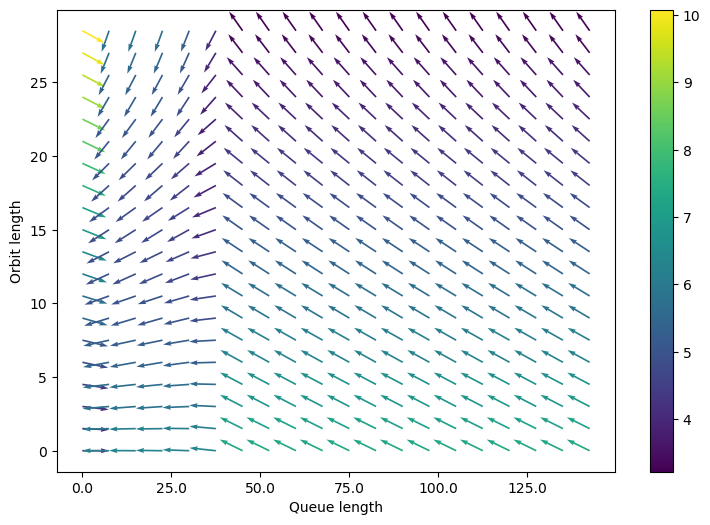

Program:  PisaSimulationSandbox
Client 	 -->	  PisaSim
Servers:  	 PisaSim: serves delayedEcho@10.000000 [q 150 orbit 30 threads 1]
Sources:  	 Client: generates delayedEcho: (arr 4.142857, to 5, re 5)
Program:  PisaSimulationSandbox
Client 	 -->	  PisaSim
Servers:  	 PisaSim: serves delayedEcho@10.000000 [q 150 orbit 30 threads 1]
Sources:  	 Client: generates delayedEcho: (arr 4.142857, to 5, re 5)
found solution is [42.50221265 30.        ]
obj value is 0.7346938775510212
Optimization terminated successfully.


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


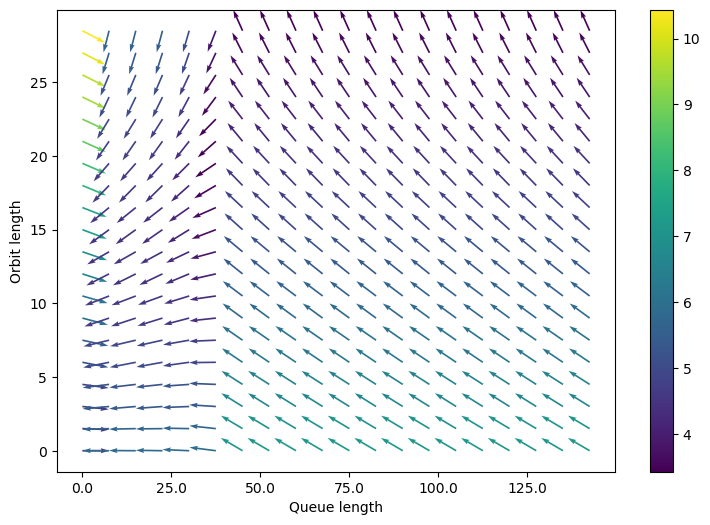

Program:  PisaSimulationSandbox
Client 	 -->	  PisaSim
Servers:  	 PisaSim: serves delayedEcho@10.000000 [q 150 orbit 30 threads 1]
Sources:  	 Client: generates delayedEcho: (arr 4.571429, to 5, re 5)
Program:  PisaSimulationSandbox
Client 	 -->	  PisaSim
Servers:  	 PisaSim: serves delayedEcho@10.000000 [q 150 orbit 30 threads 1]
Sources:  	 Client: generates delayedEcho: (arr 4.571429, to 5, re 5)
found solution is [42.57704573 30.        ]
obj value is 0.2627750318877564
Optimization terminated successfully.


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


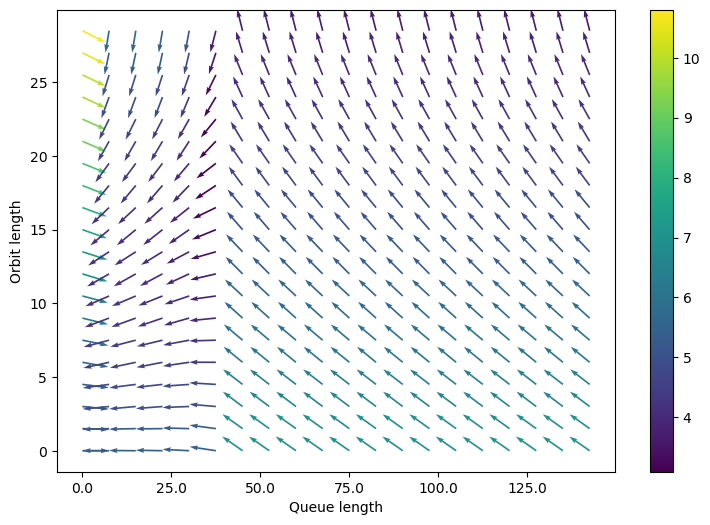

Program:  PisaSimulationSandbox
Client 	 -->	  PisaSim
Servers:  	 PisaSim: serves delayedEcho@10.000000 [q 150 orbit 30 threads 1]
Sources:  	 Client: generates delayedEcho: (arr 5.000000, to 5, re 5)
Program:  PisaSimulationSandbox
Client 	 -->	  PisaSim
Servers:  	 PisaSim: serves delayedEcho@10.000000 [q 150 orbit 30 threads 1]
Sources:  	 Client: generates delayedEcho: (arr 5.000000, to 5, re 5)
found solution is [42.83476185 30.        ]
obj value is 0.3164062500000022
Optimization terminated successfully.


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


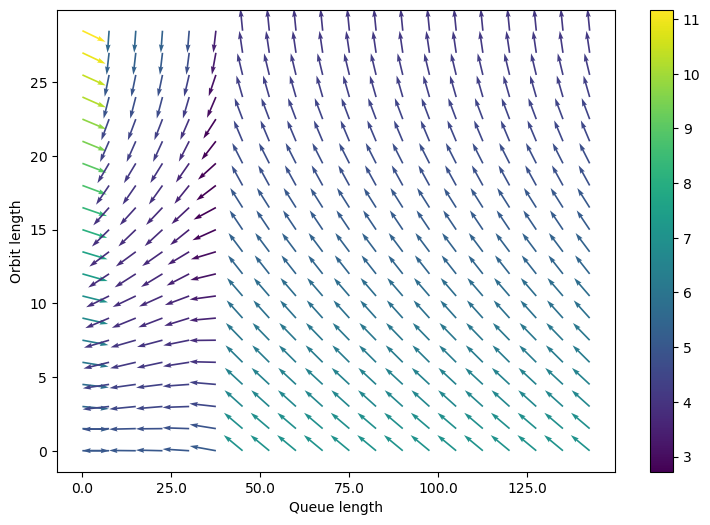



Running experiment with parameters  {'source': {'Client': {'arrival_rate': np.float64(2.0)}}}
Program:  PisaSimulationSandbox
Client 	 -->	  PisaSim
Servers:  	 PisaSim: serves delayedEcho@10.000000 [q 150 orbit 30 threads 1]
Sources:  	 Client: generates delayedEcho: (arr 2.000000, to 5, re 5)
Program:  PisaSimulationSandbox , Number of states =  4500
Average queue =  0.25002432126959645
Maximum error in solving the linear equation is 6.252776074688882e-13
Param setting =  {'source': {'Client': {'arrival_rate': np.float64(2.0)}}}  Hitting time =  30.35386263061023  s.d.= 5.909465997071877
Analysis time =  23.34943199157715  seconds
Running experiment with parameters  {'source': {'Client': {'arrival_rate': np.float64(2.4285714285714284)}}}
Program:  PisaSimulationSandbox
Client 	 -->	  PisaSim
Servers:  	 PisaSim: serves delayedEcho@10.000000 [q 150 orbit 30 threads 1]
Sources:  	 Client: generates delayedEcho: (arr 2.428571, to 5, re 5)
Program:  PisaSimulationSandbox , Number of st

In [21]:
# As queues get large, hitting times should increase
p = new_program(baseline_rps, queue_bound=150)
arates = Parameter(("source", "Client", "arrival_rate"), linspace(2, 5, 8))
v = Visualizer(p)
v.visualize(ParameterList([arates]))

t = SweepHittingTimes(p, 1.0, 0.98) # how much time does it take a 98% filled queue to get to the average queue
t.sweep(ParameterList([arates]))

In [ ]:
name = 'Pisa'
op = 'delayedEcho'
service_time_avg = 0.1
effective_num_threads = 1
baseline_rps = 5
timeout = 5
retries = 5
queue_bound = 181

#service_time_dists = {op: ExponentialDelayDistribution(service_time_avg)}
def ctmc_program(rps: int, queue_bound: int, orbit: int = 60):
    api = {op: Work(1/service_time_avg, []) }
    server = Server(name, api, qsize=queue_bound, orbit_size=orbit, thread_pool=effective_num_threads)
    src = Source('client', op, rps, timeout=timeout, retries=retries)

    p = Program(name)
    p.add_server(server)
    p.add_source(src)
    p.connect('client', name)
    return p

def visualize(p: Program, rps: int):
    v = Visualizer(p)
    v.visualize(show_equilibrium=False)


Program:  Pisa
client 	 -->	  Pisa
Servers:  	 Pisa: serves delayedEcho@10.000000 [q 181 orbit 60 threads 1]
Sources:  	 client: generates delayedEcho: (arr 5.000000, to 5, re 5)


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:478: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


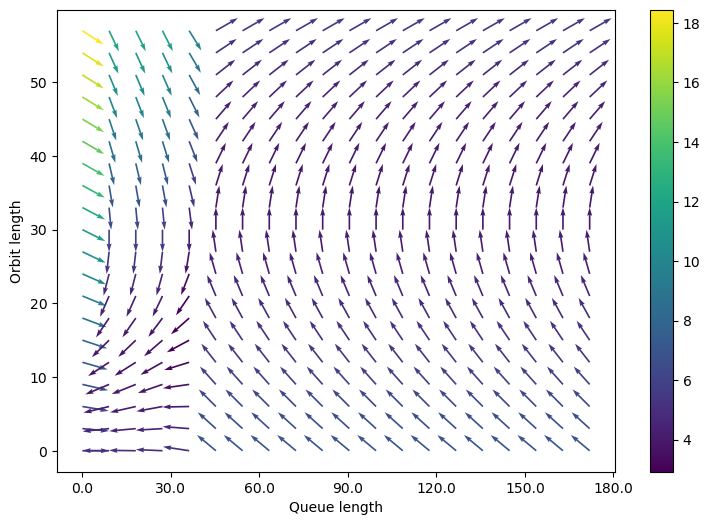

In [23]:
p = ctmc_program(baseline_rps, effective_queue_bound)
visualize(p, baseline_rps)